GT4Py - GridTools4Py - GridTools for Python

Copyright (c) 2014-2019, ETH Zurich
All rights reserved.

This file is part the GT4Py project and the GridTools framework.
GT4Py is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the
Free Software Foundation, either version 3 of the License, or any later
version. See the LICENSE.txt file at the top-level directory of this
distribution for a copy of the license or check <https://www.gnu.org/licenses/>.
SPDX-License-Identifier: GPL-3.0-or-later


## Imports and utilities

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gt4py as gt
from gt4py import ir
import gt4py.gtscript as gtscript

# Utilities for pretty printing IRs
import json
import uuid

from IPython.display import display_javascript, display_html, display


# JSON pretty printer from:
#    https://www.reddit.com/r/IPython/comments/34t4m7/lpt_print_json_in_collapsible_format_in_ipython/
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)
    

def show_ir(ir_object):
    return RenderJSON(ir.dump_ir(ir_object, as_json=True))


## Some configs

In [2]:
backend="numpy" # "debug", "numpy" or "gtx86"
N = 100 # domain is N x N x Nk (-halo)
Nk = 10
rebuild=True # if False, the stencil is only compiled the first time. (or if the stencil changes)

## Define Stencil in GTScript

In [3]:
start_time = time.time()



build_info = {} # optional dictionary to recover the generated IIRs

# just diffusion
@gtscript.stencil(backend=backend, rebuild=rebuild, build_info=build_info) # this decorator triggers compilation of the stencil
def diffusion(c_in: gtscript.Field[float], c_out: gtscript.Field[float], *, weight: float):
    with computation(PARALLEL), interval(...):
        c_out = c_in + weight*(- 4.0 * c_in[0, 0, 0] + (c_in[1, 0, 0] + c_in[-1, 0, 0] + c_in[0, 1, 0] + c_in[0, -1, 0])) 
halo_size = 1
origin = (1, 1, 0)

# # horizontal diffusion stencil
# @gtscript.stencil(backend=backend, rebuild=rebuild, build_info=build_info) # this decorator triggers compilation of the stencil
# def diffusion(u: gtscript.Field[float], diffusion: gtscript.Field[float], *, weight: float):
#     with computation(PARALLEL), interval(...):
#         laplacian = 4.0 * u[0, 0, 0] - (u[1, 0, 0] + u[-1, 0, 0] + u[0, 1, 0] + u[0, -1, 0])
#         flux_i = laplacian[1, 0, 0] - laplacian[0, 0, 0]
#         flux_j = laplacian[0, 1, 0] - laplacian[0, 0, 0]
#         diffusion = u[0, 0, 0] - weight * (
#             flux_i[0, 0, 0] - flux_i[-1, 0, 0] + flux_j[0, 0, 0] - flux_j[0, -1, 0]
#         )
# halo_size = 2
# origin = (2, 2, 0)

print('\nCode generation and compilation took', time.time() - start_time, 'seconds.')



Code generation and compilation took 0.1064305305480957 seconds.


## Initialize Data

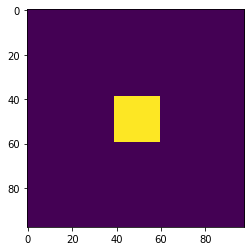

In [4]:
def rectangle2d(i, j, domain):
    center = [(int(d)/2) for d in domain]
    size = [(int(d)/10) for d in domain]
    return 0 if any([abs(c-i)>s for c,s,i in zip(center, size, (i,j))]) else 1/(8*np.product(size)) 

init_f = rectangle2d


c_in_data = np.zeros((N, N, Nk))
for i in range(halo_size,N-halo_size):
    for j in range(halo_size,N-halo_size):
        for k in range(Nk):
            c_in_data[i,j,k] = init_f(i,j,[N]*2)
c_out_data = np.zeros_like(c_in_data)


plt.imshow(c_in_data[halo_size:N-halo_size,halo_size:N-halo_size,int(Nk/2)])
plt.show()

In [5]:
import gt4py.storage as gt_storage

c_in = gt_storage.from_array(data=c_in_data, backend=backend, default_origin=origin, shape=(N, N, Nk))
c_out = gt_storage.from_array(data=c_out_data, backend=backend, default_origin=origin, shape=(N, N, Nk))

## Apply Stencil

Computations took 0.6213653087615967 seconds.


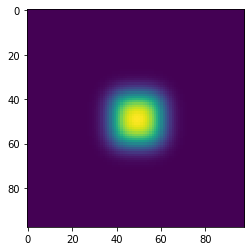

In [6]:
niter = 1000
c_in_bak = np.array(c_in)

start_time = time.time()
for i in range(niter):
    # actual application of the stencil
    diffusion(c_in, c_out, weight=0.01, origin={'c_out':(1,1,0)}) 
    c_tmp = c_out
    c_out = c_in
    c_in = c_tmp
    

print('Computations took', time.time() - start_time, 'seconds.')

c_tmp = c_out
c_out = c_in
c_in = c_tmp
plt.imshow(c_out.data[halo_size:N-halo_size,halo_size:N-halo_size,int(Nk/2)])
plt.show()

## Generated IIR
The generated IIR can be inspected by inspecting the `build_info` dictionary:

In [7]:
print(build_info.keys())
def_ir = build_info['def_ir']
iir = build_info['iir']

show_ir(iir)

dict_keys(['def_ir', 'iir', 'symbol_info'])
